In [1]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

from mesa.time import RandomActivation
from mesa.space import MultiGrid
import random

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class EconomicAgent(mesa.Agent):
    def __init__(self, unique_id, model, initial_wealth, norm):
        super().__init__(unique_id, model)
        self.wealth = initial_wealth
        self.norm = norm
    
    def step(self):
        self.generate_wealth()
        self.trade()
        self.update_norm()

    def get_utility(self):
        if self.norm == 'self-centric':
            return self.wealth
        elif self.norm == 'altruistic':
            # Compute the gini coefficient of the wealth distribution.
            wealths = [agent.wealth for agent in self.model.schedule.agents]
            gini = self.model.compute_gini(wealths)
            return self.wealth + self.wealth * (1 - gini)

    def generate_wealth(self):
        # Proportional wealth increase.
        self.wealth *= 1 + self.model.growth_rate

        # Fixed wealth increase which emulates a salary from a job. # This should depend on employment status.
        self.wealth += self.model.salary

    def trade(self):
        # Randomly select a trading partner.
        partner = self.random.choice(self.model.schedule.agents)

        # Check if partner is self.
        if partner == self:
            return
        
        # Wealth transfer.
        wealthier, poorer = (self, partner) if self.wealth > partner.wealth else (partner, self)

        # Transfer a portion of wealth based on the trade rate.
        transfer = self.model.trade_rate * wealthier.wealth

        # Transfer the wealth if it improves the poorer agent's wealth
        if poorer.wealth + transfer >= poorer.wealth:
            wealthier.wealth -= transfer
            poorer.wealth += transfer

    def update_norm(self):
        if self.norm == 'self-centric':
            # Interact with random agent
            partner = self.random.choice(self.model.schedule.agents)

            # Check the norm of the partner
            if partner.norm == 'altruistic':
                current_utility = self.get_utility()
                partner_utility = partner.get_utility()

                # Check if the partner's utility is greater than the current utility
                if partner_utility > current_utility:
                    # Check if the conversion probability is met
                    if self.random.random() < self.model.conversion_probability:
                        self.norm = 'altruistic'

        elif self.norm == 'altruistic':
            # Interact with random agent
            partner = self.random.choice(self.model.schedule.agents)

            # Check the norm of the partner
            if partner.norm == 'self-centric':
                current_utility = self.get_utility()
                partner_utility = partner.get_utility()

                # Check if the partner's utility is greater than the current utility
                if partner_utility > current_utility:
                    # Check if the conversion probability is met
                    if self.random.random() < self.model.conversion_probability:
                        self.norm = 'self-centric'




class EconomicModel(mesa.Model):
    def __init__(self, num_agents, initial_wealth, growth_rate, trade_rate, salary, conversion_probability, social_pressure_probability, ratio_of_altruistic_agents):
        self.num_agents = num_agents
        self.initial_wealth = initial_wealth
        self.growth_rate = growth_rate
        self.trade_rate = trade_rate
        self.salary = salary
        self.conversion_probability = conversion_probability
        self.social_pressure_probability = social_pressure_probability

        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width=10, height=10, torus=True)

        # Create agents
        for i in range(self.num_agents):
            norm = 'self-centric' if random.random() > ratio_of_altruistic_agents else 'altruistic'
            agent = EconomicAgent(i, self, self.initial_wealth, norm)
            self.schedule.add(agent)

            # Add the agent to a random grid cell.
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))


    def step(self):
        self.schedule.step()
        

    def compute_gini(self, wealths):
        # Sort the wealths.
        wealths = np.sort(wealths)

        # Get the number of agents.
        n = len(wealths)

        # Get the cumulative wealth.
        cumulative_wealth = np.cumsum(wealths)

        # Calculate the Lorenz curve.
        lorenz_curve = cumulative_wealth / cumulative_wealth[-1]

        # Calculate the Gini coefficient.
        gini = 1 - 2 * np.trapz(lorenz_curve)

        return gini


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_18701/1909499086.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


<Axes: xlabel='wealth', ylabel='Count'>

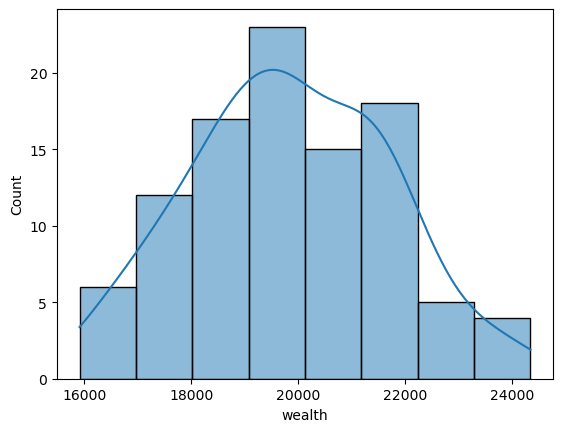

In [4]:
# Set the model parameters.
num_agents = 100
initial_wealth = 1000
growth_rate = 0.01
trade_rate = 0.1
salary = 100
conversion_probability = 0.4
social_pressure_probability = 0.1
ratio_of_altruistic_agents = 0.2

# Create the model.
model = EconomicModel(num_agents, initial_wealth, growth_rate, trade_rate, salary, conversion_probability, social_pressure_probability, ratio_of_altruistic_agents)

# Run the model.
for i in range(100):
    model.step()

# Get the wealths of the agents.
wealths = [agent.wealth for agent in model.schedule.agents]

# Create a DataFrame.
df = pd.DataFrame({'wealth': wealths})

# Plot the wealth distribution.
sns.histplot(df['wealth'], kde=True)
